#### Predict numerical rise Voltage rise 
for the next period based on value of previous periods.


RNN created and trained in [VoltageRiseNum_Train](VoltageRiseNum_Train.ipynb)

---

#### Import modules to be used

In [1]:
#Import Modules 
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf
import joblib
import ipyparallel as ipp


#### Import my own modules

In [2]:
# import psutil
function_folder = '../Modules/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
import checker
import oriClass as oriCs
from oriVariables import (network_folder,
                          simResult_folder,
                          defAuth_hvBus_vRiseMax, 
                          defAuth_hvBus_vRiseMin, 
                          h_start_end,
                          testSet_end_M1,
                          valSet_start_M2,                          
                          Δt,
                          pd_Δt,
                          lowerNet_file_loc, 
                          upperNet_file_loc, 
                          ctrld_HvProd_name, 
                          cleanedData_name
                          )

#### Import Networks


In [3]:
lowerNet=pp.from_pickle(lowerNet_file_loc)# Import the Lower Network
upperNet=pp.from_pickle(upperNet_file_loc)# Import the upper Network

# Load networks
networks = oriCs.InitNetworks(upperNet, lowerNet)

# To use later in functions 
sum_max_main_network = networks.get_upperNet_sum_max_lvProdLoad()


# Extract the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT = sum_max_main_network[0]
sum_max_p_mw_StLaurent_load = sum_max_main_network[1]

# defined Vrise
vm_mu_max, vm_mu_min = defAuth_hvBus_vRiseMax, defAuth_hvBus_vRiseMin  


#### Import Cleaned data files for component of the network

In [4]:
df_data = joblib.load(f'{simResult_folder}{cleanedData_name}')

# create daylight periods
per_index = df_data.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object)
                .between_time(*h_start_end) ).index.to_period(pd_Δt)

# Extract daylight periods
df_data = df_data.loc[per_daylight]

df_final = df_data[(df_data.index>= valSet_start_M2) & (df_data.index<= testSet_end_M1)]

# # Extract extract only testing set
df_final = df_data[(df_data.index>= valSet_start_M2) & (df_data.index<= testSet_end_M1)]
per_index = df_final.index

#### Data extraction on the network

In [6]:
lowerNet_hv_bus = networks.get_lowerNet_hv_bus_df() # Extract HV bus in the network

pp.runpp(lowerNet) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index = list(lowerNet.res_bus.vm_pu[lowerNet.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
lowerNet_hv_activated_bus = [i for i in activated_bus_index 
                               if i in lowerNet_hv_bus.index]

# redefine data given final pandas.DataFrame
df_prodHT = df_final.iloc[:,2:]
df_prod_bt_total = df_final.iloc[:,[1]]
df_cons_total = df_final.iloc[:,[0]]

# Define a dict 
dict_df_sgenLoad = dict({'df_prodHT':df_prodHT, 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total, 
                         'lowerNet_sgenDf_copy': lowerNet.sgen.copy(deep=True)} )

#### Start Parallel engines

In [ ]:
n_engines = os.cpu_count() - 1
# (Use the real maximum cpu and not the logical)            
cluster = ipp.Cluster(n=n_engines) # Create cluster
cluster.start_cluster_sync()       # Start cluster 
rc = cluster.connect_client_sync() # connect client
rc.wait_for_engines(n_engines)     # Wait for engines to be available for all clients
dview = rc[:]                      # Create a direct view of all engine or clients that would
                                   # be used to command each client

### No Control 

#### Send data into local space of each engine

In [17]:
# Import following modules on the local space of clients or engines
with rc[:].sync_imports():
    import numpy
    import pandapower
    import pandas
    import sys

# Add modules location to Par engines namespace
dview[f'sys.path.append("{function_folder}")']

with rc[:].sync_imports(): # import from modules_folder
    import oriFunctions
    
# Share the total number of simulation period among all the engines
dview.scatter('period',per_index)


# Create a dictionnary containing all the varible that will be used by each client or engine
opf_status = False 
parameters_dict = dict({'lowerNet':lowerNet, 
                        'lowerNet_hv_activated_bus':lowerNet_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'dict_df_sgenLoad':dict_df_sgenLoad, 
                        'vm_mu_max':vm_mu_max,
                        'opf_status':opf_status})

dview.push(parameters_dict) # Add all  variables in the parameters_dict 
                            # to  the local space of each client engine(s)

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing sys on engine(s)
importing oriFunctions on engine(s)


<AsyncResult(_push): pending>

#### Run power flow in each local engine

In [18]:
%%px 
resulting = [oriFunctions.run_powerflow_at(lowerNet, cur_period, lowerNet_hv_activated_bus, 
                                               sum_max_main_network, dict_df_sgenLoad, opf_status) for cur_period in period]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

In [19]:
# Gather the result of each engine in a sigle list
list_max_vm_pu = dview.gather('resulting')

#### Plot the maximum voltage on the network 

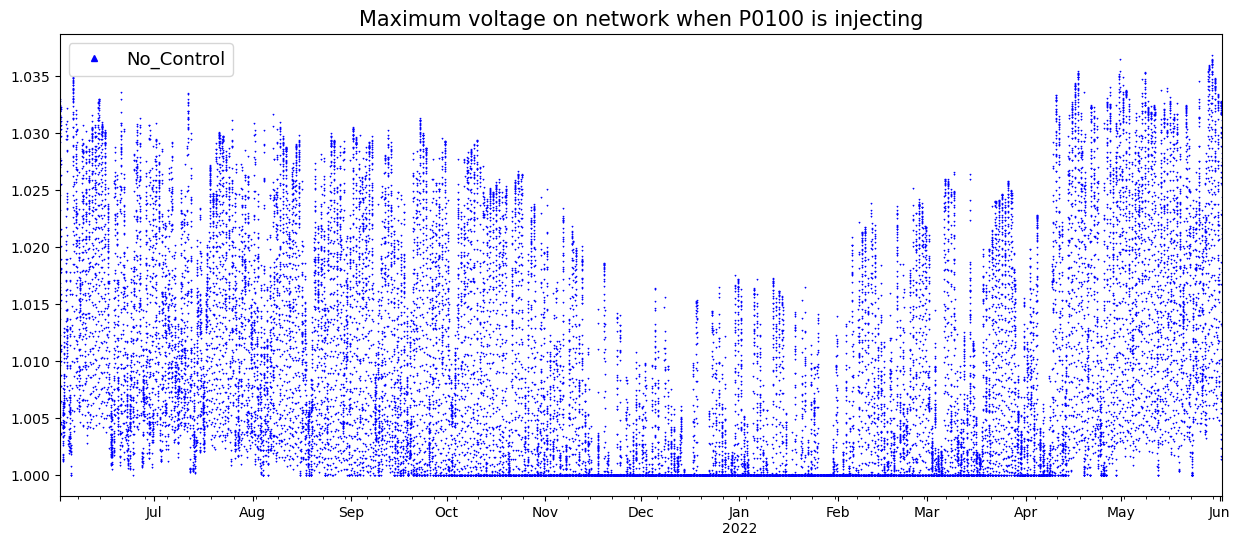

In [24]:
max_vm_pu_df = pd.DataFrame(data=np.array(list_max_vm_pu)[:,0], 
                            index=np.array(list_max_vm_pu)[:,1], columns=['No_Control'])
fig, axx = plt.subplots(figsize=(15,6))
max_vm_pu_df.plot(ax=axx, style='b^',markersize=0.5,)

plt.legend( fontsize=13, markerscale=10)
plt.title(f"Maximum voltage on network when {ctrld_HvProd_name} is injecting", fontsize=15);
# plt.xlim(['2020 01 01', '2020 01 03'])

#### Import the numerical voltage rise prediction model i.e. Trained in [here](VoltageRiseNum_Train.ipynb)


In [ ]:
# Import the voltage rise
numVriseModel = tf.keras.models.load_model(f'{network_folder}RNN/StLaurent_num_vRise_model')
scaler_train = joblib.load(f'{network_folder}RNN/StLaurent_num_vRise_scaler.plk')
scaler_features = joblib.load(f'{network_folder}RNN/StLaurent_num_vRise_scalerPred.plk')

### Set variables For numerical voltage rise prediction

In [26]:
# Create the dataframe to work with
working_df = df_final.copy(deep=True)

# add the voltage rise column to the working df
col_name = scaler_features.feature_names_in_[1] # Get the name that were used during the training process
working_df[col_name] = max_vm_pu_df.No_Control.values

#### Create dataset i.e. history that would be used to predict 

In [27]:
n_period = numVriseModel.input_shape[-1] # Get total number of periods or lags to 
                                         # consider to predict from the model to use
history = working_df.rolling(n_period)   # create a rolling history based on the total numbers of lags

hist_list = list(history)[n_period-1:]   # Conveert %history in a list

len_hist = len(hist_list)                # Get the len of the history list

#### Run predictions 
**<span style='color:red'> Bloc Pred using an RNN </span>**

In [28]:
pred_per, pred = [],[]             
                
for hist_index in tqdm(range(len_hist)):
    cur_hist = hist_list[hist_index]          # current hystory
    # run prediction for each period 
    pred_var, pred_per_var = oriFc.prediction_bloc(rnn_model=numVriseModel, 
                                                fitting_scaler=scaler_train, 
                                                history=cur_hist, 
                                                scaler_features=scaler_features)
    
    pred_per.append(pred_per_var)
    pred.append(pred_var)
    


100%|██████████| 26347/26347 [22:33<00:00, 19.46it/s]


In [ ]:
predicted_values = pd.DataFrame(data = np.array(pred).reshape((-1,2))[:,1],
                                index=pred_per, 
                                columns = ['V_rise_Pred'] )

per_index3 = ( pd.Series(index=predicted_values.index.to_timestamp(), dtype=object
                           ).between_time('08:00','18:50') ).index.to_period(pd_Δt)

### Scatter Plot Prediction vs Real values

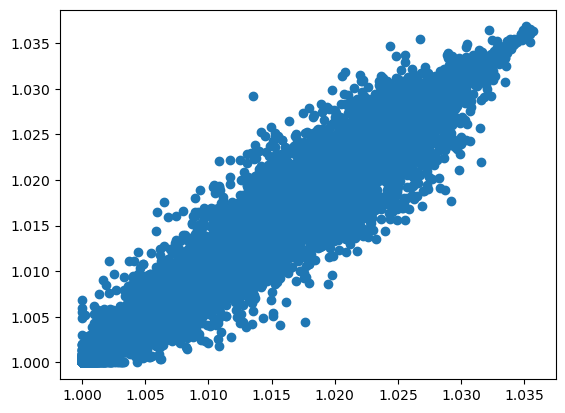

In [157]:
plt.scatter(predicted_values.loc[per_index3],working_df.loc[per_index3, ['Volt_Rise_num']])

In [ ]:
pd.Series((predicted_values.loc[per_index3]>vm_mu_max).values.reshape(-1)).value_counts()

False    21922
True      2234
dtype: int64

In [ ]:
pd.Series((working_df.loc[per_index3, ['Volt_Rise_num']]>vm_mu_max).values.reshape(-1)).value_counts()

False    21608
True      2548
dtype: int64

In [189]:
joblib.dump(predicted_values, f'{simResult_folder}Numerical_Voltage_Rise_Predicted.pkl',)

['pickle_files/simulationResults/Numerical_Voltage_Rise_Predicted.pkl']

---